In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP%20Course%20-%20Week%203%20Exercise%20Answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.3.0
!pip install tensorflow-datasets==3.2.1
!pip install Pillow==7.2.0

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 460kB 24.1MB/s 
     |████████████████████████████████| 20.1MB 173kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


     |████████████████████████████████| 3.4MB 21.9MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
     |████████████████████████████████| 2.2MB 15.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []


In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)


--2020-12-24 03:12:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.112, 172.217.2.112, 172.217.8.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   220MB/s    in 1.0s    

2020-12-24 03:12:59 (220 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [3]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [4]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [5]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138179
1


In [6]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-12-24 03:13:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 172.217.15.112, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   145MB/s    in 2.3s    

2020-12-24 03:13:40 (145 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [7]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138180


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13818000  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,883,153
Trainable params: 65,153
Non-trainable params: 13,818,000
_______________________________________

<Figure size 432x288 with 0 Axes>

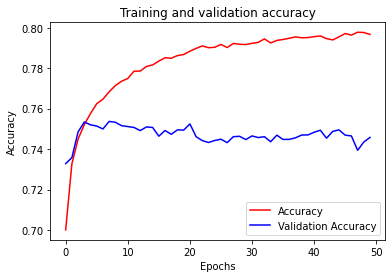

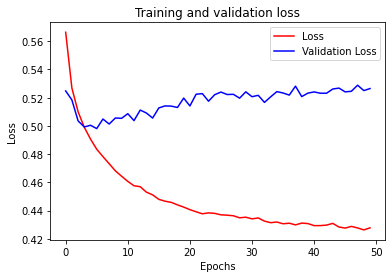

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [10]:
model.save("model_week3.h5")